In [2]:
import numpy as np
import pandas as pd
import librosa
import librosa.feature
import librosa.display
import matplotlib.pyplot as plt
import glob
import os
from scipy import stats
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
import jams
import matplotlib.lines as mlines

/Users/saksham/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<font size = 4> <b> Functions

<font size = 4> Feature Extraction

In [6]:
def power_cepstrum(x, w, n_fft, hop_length, n_lift):
    """
    Inputs - x: Audio File; w: Window; n_fft: fft size; hop_length: hop size; n_lift: Number of cepstral coefficients to filter out
    Output - cepstrum: real valued 2-D numpy array consisting of n_lift cepstral coefficients per frame
    """
    
    if (hop_length <= 0):                                   # raise error if hop size 0 or negative
        raise ValueError("Hop size (H) smaller or equal to 0")

    M = w.size                                     # size of analysis window
    hM1 = (M+1)//2                                 # half analysis window size by rounding
    hM2 = M//2                                     # half analysis window size by floor
    x = np.append(np.zeros(hM2),x)                 # add zeros at beginning to center first window at sample 0
    x = np.append(x,np.zeros(hM1))                 # add zeros at the end to analyze last sample
    pin = hM1                                      # initialize sound pointer in middle of analysis window       
    pend = x.size-hM1                              # last sample to start a frame
    w = w / sum(w)                                 # normalize analysis window
    cepstrum = []
    while pin<=pend:                               # while sound pointer is smaller than last sample        
        x1 = x[pin-hM1:pin+hM2] * w                    # select one frame of input sound       
        fft_x1=np.fft.fft(x1,n_fft)
        fft_x1_power = (abs(fft_x1))**(1/3)
    #-----IFFT
        cep_frame = np.fft.ifft(fft_x1_power, n_fft)        
        cepstrum.append(cep_frame[1:n_lift])
        pin += hop_length                                   # advance sound pointer
    cepstrum = abs(np.array(cepstrum))
    return cepstrum

def features_extract(audio, w, n_fft, hop_length, n_lift):
    """returns CP (n-lift coefficients), variance, kurtosis and skewness of n_lift power cepstral
    coefficients as input features to the model"""
    coefficients = []
    CP = []
    for x in audio:
        CP_onset = power_cepstrum(x, w, n_fft, hop_length, n_lift)
        CP.append(CP_onset)
    CP = np.array(CP)
    
    # Variance
    CP_var = []
    for i in np.arange(CP.shape[0]):
        CP_var_file = np.array([])
        for coeff in np.arange(n_lift-1):
            CP_var_coeff = np.var(CP[i][:, coeff])
            CP_var_file = np.append(CP_var_file, CP_var_coeff)
        CP_var.append(CP_var_file)
        
    # Kurtosis
    CP_kurt = []
    for i in np.arange(CP.shape[0]):
        CP_kurt_file = np.array([])
        for coeff in np.arange(n_lift-1):
            CP_kurt_coeff = stats.kurtosis(CP[i][:, coeff])
            CP_kurt_file = np.append(CP_kurt_file, CP_kurt_coeff)
        CP_kurt.append(CP_kurt_file)
        
    # Skewness
    CP_skew = []
    for i in np.arange(CP.shape[0]):
        CP_skew_file = np.array([])
        for coeff in np.arange(n_lift-1):
            CP_skew_coeff = stats.skew(CP[i][:, coeff])
            CP_skew_file = np.append(CP_skew_file, CP_skew_coeff)
        CP_skew.append(CP_skew_file)
    
    coefficients.append(CP_var)
    coefficients.append(CP_kurt)
    coefficients.append(CP_skew)
    coefficients = np.array(coefficients)
    return coefficients, CP

# Function to generate column names for dataframe containing feature vectors

def column_name_gen(feature, n_lift):
    """Generate column names for final feature dataframe as per the feature name and coefficient number"""
    feature_name = []
    for i in np.arange(1, n_lift):
        feature_coeff = feature + '_C' + str(i)
        feature_name.append(feature_coeff)
    return feature_name


# Function to extract var, kurt and skew from all audio files and append them in a dataframe

def feature_vector_data(coefficients, n_lift):
    """Creating a dataframe containing all the features for all onsets"""
    CP_var = coefficients[0]
    CP_kurt = coefficients[1]
    CP_skew = coefficients[2]
    CP_var_df = pd.DataFrame(CP_var)
    CP_var_name = column_name_gen('CP_var', n_lift)
    CP_var_df.columns = CP_var_name
    CP_kurt_df = pd.DataFrame(CP_kurt)
    CP_kurt_name = column_name_gen('CP_kurt', n_lift)
    CP_kurt_df.columns = CP_kurt_name
    CP_skew_df = pd.DataFrame(CP_skew)
    CP_skew_name = column_name_gen('CP_skew', n_lift)
    CP_skew_df.columns = CP_skew_name
    
    feature_vector_all = pd.concat([CP_var_df, CP_kurt_df, CP_skew_df], axis = 1)
    return feature_vector_all
    

<font size = 4> Onset detection from NYU GuitarSet

In [174]:
def visualize_jams_onset_asList(jam, save_path=None, low=None, high=None, visualize=False):

    """ - Reading time location of all onsets detected in selected audio
    - Input parameters:
        1. jam: jams file to read annotations
    - Output: 2-D numpy array (onset time, string)
    """

    onsetList = []

    style_dict = {0 : 'r', 1 : 'y', 2 : 'b', 3 : '#FF7F50', 4 : 'g', 5 : '#800080'}
    string_dict = {0: 'E', 1: 'A', 2: 'D', 3: 'G', 4: 'B', 5: 'e' }
    s = 0
    handle_list = []
    if visualize:
        plt.figure(figsize=(16, 5))
    annos = jam.search(namespace='note_midi')
    if len(annos) == 0:
        annos = jam.search(namespace='pitch_midi')
    for string_tran in annos:
        handle_list.append(mlines.Line2D([], [], color=style_dict[s],label=string_dict[s]))
        for note in string_tran:

            start_time = note[0]

            if low and start_time < low:
                continue
            if high and start_time > high:
                continue

            onsetList.append([start_time, s])

            if visualize:
                plt.vlines(start_time,s, s+1,style_dict[s], label=string_dict[s])
        s += 1

    if visualize:
        plt.xlabel('sec')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), handles=handle_list)
        plt.ylabel('String Number')

    if not low:
        low = -0.1
    if not high:
        high = jam.file_metadata.duration

    if visualize:
        plt.xlim(low, high)
    # fig.set_size_inches(jam.file_metadata.duration / 2.5, 6)
    #    plt.title('Onsets of Individual Strings for excerpt of 00_Rock2-142-D_comp')
    if save_path:
        plt.savefig(save_path)


    onsetList.sort(key=lambda x: x[0])
    onsetList = np.array(onsetList)

    return onsetList

def onset_by_string(onsetList):
    """
    - Combining onsets by string in one list item
    - Input parameter: onsetList (output of visualize_jams_onset_asList)
    - Output: numpy array containing arrays by strings that further contain all onsets on that string

    """    
    onsetList = np.array(onsetList)
    onsetString = []
    for string in np.arange(6.):
        onsets = np.where(onsetList[:, 1] == string)
        onsets = onsetList[onsets, 0][0]
        onsetString.append(onsets)
    
    onsetString = np.array(onsetString)
    return onsetString



def clip_from_onset(onsetList, SAMPLE_RATE):
    """
    - Reading 0.4s data around detected onset. 
    - Audio has been clipped according to Taiwan Dataset (0.1s before the onset and 0.3s after the onset)
    - Input parameters:
        1. onsetString (output of onset_by_string)
        2. SAMPLE_RATE
    - Output:
        1. array containing 0.3s time domain signal per onset
    """
# 0.1s time frame before detected onset
    ta = int(0.2 * SAMPLE_RATE)
# 0.2s time frame after detected onset
    tb = int(0.2 * SAMPLE_RATE)
    all_segments = []
    
#     for string in np.arange(6):
#         string_segments = []
#         for note in np.arange(len(onsetString[string])):
#             time = onsetString[string][note]
#             sample = int(np.round(time * SAMPLE_RATE))
#             if sample > ta:
#                 x = audio_hex[string][sample-ta:sample+tb]
#             if sample <=ta:
#                 x = audio_hex[string][:sample+tb]
#             all_segments.append(x)   
#     all_segments = np.array(all_segments)

    for onset in onsetList[:, 0]:
        sample = int(np.round(onset * SAMPLE_RATE))
        string = int(onsetList[list(onsetList[:, 0]).index(onset), 1])
        if sample > ta:
            x = audio_hex[string][sample-ta:sample+tb]
        if sample <=ta:
            x = audio_hex[string][:sample+tb]
        all_segments.append(x) 
    
    return all_segments


def clip_from_onset_multiplefiles(onsetList, SAMPLE_RATE, audio, pre = 0.1, post = 0.2):
    """
    - Reading 0.4s data around detected onset. 
    - Audio has been clipped according to Taiwan Dataset (0.1s before the onset and 0.3s after the onset)
    - Input parameters:
        1. onsetString (output of onset_by_string)
        2. SAMPLE_RATE
    - Output:
        1. array containing 0.3s time domain signal per onset
    """
# 0.1s time frame before detected onset
    ta = int(pre * SAMPLE_RATE)
# 0.2s time frame after detected onset
    tb = int(post * SAMPLE_RATE)
    all_segments = []

    for onset in onsetList[:, 0]:
        sample = int(np.round(onset * SAMPLE_RATE))
        string = int(onsetList[list(onsetList[:, 0]).index(onset), 1])
        if sample > ta:
            x = audio[string][sample-ta:sample+tb]
        if sample <=ta:
            x = audio[string][:sample+tb]
        all_segments.append(x) 
    
    return all_segments

<font size = 4> <b> Reading onset from single hex file in NYU GuitarSet

In [161]:
# Reading single annotation and corresponding audio file
annotation_file = 'GuitarSet/annotation/00_Jazz3-150-C_solo.jams'
audio_hex_file = 'GuitarSet/audio/audio_hex-pickup_original/00_Jazz3-150-C_solo_hex.wav'
audio_mono_file = 'GuitarSet/audio/audio_mic/00_BN1-129-Eb_solo_mic.wav'

annotation = jams.load(annotation_file)
audio_hex, SAMPLE_RATE = librosa.load(audio_hex_file, mono = False)
audio_mono, SAMPLE_RATE_mono = librosa.load(audio_mono_file)

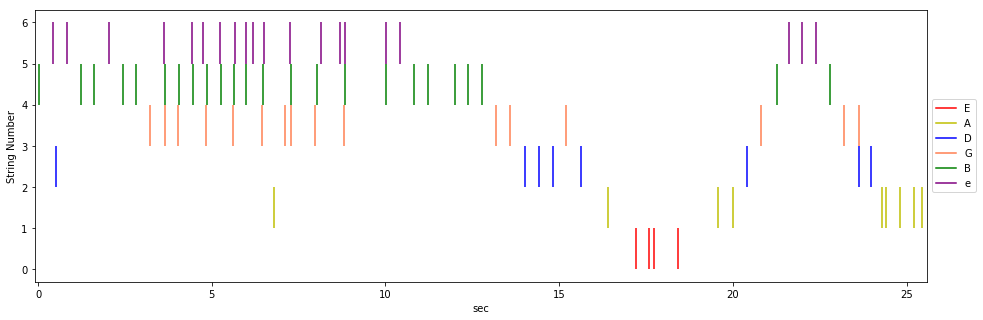

In [9]:
onsetList = visualize_jams_onset_asList(annotation, visualize = True)
onsetList = np.array(onsetList)

In [17]:
# Getting all onset clips
onsetsClips = clip_from_onset(onsetList, SAMPLE_RATE)

In [277]:
annotation_track = jams.load(annotation_file)
onset_track = visualize_jams_onset_asList(annotation_track, visualize = False)

# Reading onset on 1st string
onset_frames = librosa.onset.onset_detect(audio_hex[0], sr=SAMPLE_RATE, wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1)
onset_times = librosa.frames_to_time(onset_frames, sr = SAMPLE_RATE)
onset_samples = onset_times * int(SAMPLE_RATE)
onset_times

array([ 0.46439909,  2.46131519,  3.66875283,  4.48145125, 10.84371882,
       12.02793651, 12.42267574, 14.44281179, 15.23229025, 15.65024943,
       16.41650794, 17.20598639, 17.60072562, 17.74004535, 18.43664399,
       20.01560091, 20.43356009, 21.52489796, 22.01251701, 22.40725624,
       22.82521542, 23.21995465, 24.42739229, 24.84535147, 25.44907029])

In [311]:
# Generate librosa onsets
def librosa_onsets(audio_hex, sr, onset_track):
    """
    Inputs: 
    - audio_hex: Audio file containing six channels
    - sr: SAMPLE RATE
    - onset_track: annotated onsets corresponding to audio_hex
    
    Returns: Matrix with n (number of onsets) tuple items. Within tuple, 0th element is the onset time and 
    1st element is the onset string for the closest onset detected by librosa with a maxerror (maximum distance
    between annotated onset and librosa onset) = 0.1

    """
    maxerror = 0.1
    librosa_onsets_detect = []
    librosa_onsets = []
    for string in np.arange(len(audio_hex)):
        onset_frames = librosa.onset.onset_detect(audio_hex[string], sr=SAMPLE_RATE, wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1)
        onset_times = librosa.frames_to_time(onset_frames, sr = SAMPLE_RATE)
        for location in onset_track:
            if location[1] == string:
                onset_loc = np.argmin(np.abs(onset_times-location[0]))
                if np.abs(onset_times[onset_loc] - location[0]) < maxerror:
                    onset = np.append(onset_times[onset_loc], string)
                    librosa_onsets.append(onset)
    librosa_onsets = np.array(librosa_onsets)
    return librosa_onsets
    

In [312]:
librosa_onsets_track = librosa_onsets(audio_hex, SAMPLE_RATE, onset_track)
print (len(librosa_onsets_track))
print (len(onset_track))
print (librosa_onsets_track)

73
81
[[17.20598639  0.        ]
 [17.60072562  0.        ]
 [17.74004535  0.        ]
 [18.43664399  0.        ]
 [16.39328798  1.        ]
 [19.57442177  1.        ]
 [19.99238095  1.        ]
 [24.40417234  1.        ]
 [24.82213152  1.        ]
 [25.2400907   1.        ]
 [25.44907029  1.        ]
 [ 0.46439909  2.        ]
 [14.02485261  2.        ]
 [14.41959184  2.        ]
 [14.81433107  2.        ]
 [15.62702948  2.        ]
 [20.41034014  2.        ]
 [23.63791383  2.        ]
 [24.00943311  2.        ]
 [ 3.2275737   3.        ]
 [ 3.64553288  3.        ]
 [ 4.01705215  3.        ]
 [ 4.85297052  3.        ]
 [ 5.59600907  3.        ]
 [ 6.45514739  3.        ]
 [ 7.2678458   3.        ]
 [ 7.9876644   3.        ]
 [13.18893424  3.        ]
 [13.60689342  3.        ]
 [15.20907029  3.        ]
 [20.82829932  3.        ]
 [23.21995465  3.        ]
 [23.63791383  3.        ]
 [ 1.2306576   4.        ]
 [ 1.60217687  4.        ]
 [ 2.43809524  4.        ]
 [ 2.83283447  4.     

<font size = 4> <b> Extracting cepstral coefficients from 1 file

In [116]:
# Parameters
w = np.hamming(1024)
n_lift = 200
n_fft = 1024
hop_length = 200

In [12]:
# Extracting cepstral coefficients of all onsets
coefficients, CP = features_extract(onsetsClips, w, n_fft, hop_length, n_lift)

/Users/saksham/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


In [13]:
feature_vectors = feature_vector_data(coefficients, n_lift)

<font size = 4> <b> Extracting feature vector for all files

In [14]:
def solo_annotation_files(annotation_files):
    """Read just the solo annotation files from a folder (out of both, solo and comp annotations)"""
    solo_annotations = []
    for i in np.arange(len(annotation_files)):
        if annotation_files[i].split('_')[2][:4] == 'solo':
            solo_annotations.append(annotation_files[i]) 
    return solo_annotations

def audio_path_generator(solo_files, filetype = '_hex.wav', rectype = 'audio_hex-pickup_original'):
    """Generates paths of audio files to be read in the same order as annotation files"""
    audio_paths = []
    for path in solo_files:
        audio_name = path.split('/')[2][:-5] + filetype
        audio_path = path.split('/')[0] + '/audio/' + rectype + '/' + audio_name
        audio_paths.append(audio_path)
    return audio_paths

In [15]:
# Generating paths to read all types of files
annotation_paths = glob.glob("GuitarSet/annotation/*.jams")
solo_files_paths = solo_annotation_files(annotation_paths)
solo_audio_paths = audio_path_generator(solo_files_paths)

In [102]:
# Reading all audio files
all_audio_files = []
for path in solo_audio_paths:
    solo, SAMPLE_RATE = librosa.load(path, mono = False)
    all_audio_files.append(solo)

In [313]:
# Reading onset time using librosa onset detection function, picking the one closest to annotated time
all_librosa_onsets = []
for file in np.arange(len(solo_files_paths)):
    annotation_track = jams.load(solo_files_paths[file])
    onset_track = visualize_jams_onset_asList(annotation_track, visualize = False)
    librosa_onsets_track = librosa_onsets(all_audio_files[file], SAMPLE_RATE, onset_track)
    all_librosa_onsets.append(librosa_onsets_track)

<font size = 3> <b> Checking quality of onset detection

In [359]:
track = solo_files_paths[0]
print (solo_files_paths[0])
print (solo_audio_paths[0])

GuitarSet/annotation/04_Jazz2-110-Bb_solo.jams
GuitarSet/audio/audio_hex-pickup_original/04_Jazz2-110-Bb_solo_hex.wav


In [358]:
annot = jams.load(track)
onset_annot = visualize_jams_onset_asList(annot, visualize = False)
print (len(onset_annot))
print (onset_annot)

78
[[ 0.22642268  3.        ]
 [ 1.84118458  1.        ]
 [ 2.0348127   2.        ]
 [ 2.35245442  3.        ]
 [ 3.98816871  1.        ]
 [ 4.1587356   2.        ]
 [ 4.48447256  2.        ]
 [ 4.65549297  2.        ]
 [ 4.71392834  3.        ]
 [ 6.18488073  3.        ]
 [ 6.28059501  3.        ]
 [ 6.39517551  3.        ]
 [ 6.54458594  3.        ]
 [ 8.44501678  3.        ]
 [ 8.57338413  3.        ]
 [ 8.89347483  3.        ]
 [10.46547029  3.        ]
 [10.71971066  3.        ]
 [11.07674014  3.        ]
 [12.64420045  3.        ]
 [12.77764717  3.        ]
 [12.93138866  3.        ]
 [13.03506213  3.        ]
 [13.56753379  3.        ]
 [14.15533424  3.        ]
 [14.72973333  3.        ]
 [15.05111655  4.        ]
 [16.20347483  4.        ]
 [16.56587846  4.        ]
 [16.81152472  4.        ]
 [16.94562902  3.        ]
 [17.21079909  4.        ]
 [17.69336145  4.        ]
 [18.30998277  4.        ]
 [18.46011882  4.        ]
 [18.55728435  4.        ]
 [18.854722    3.        

In [317]:
# Detecting librosa onset
onset_frames = librosa.onset.onset_detect(all_audio_files[0][0], sr=SAMPLE_RATE, wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1)
onset_times = librosa.frames_to_time(onset_frames, sr = SAMPLE_RATE)
onset_times

array([ 1.85759637,  2.06657596,  2.36843537,  3.7384127 ,  3.9938322 ,
        4.13315193,  4.5046712 ,  6.19972789,  6.57124717,  8.47528345,
        8.54494331,  8.91646259, 10.47219955, 10.58829932, 10.750839  ,
       13.58367347, 14.7446712 , 15.06975057, 16.20752834, 16.57904762,
       16.83446712, 17.22920635, 17.7168254 , 18.27410431, 18.32054422,
       18.41342404, 18.87782313, 20.48      , 21.61777778, 21.80353741,
       22.19827664, 22.40725624, 22.52335601, 22.91809524, 23.19673469,
       23.9629932 , 24.33451247, 24.52027211, 24.89179138, 25.44907029,
       26.00634921, 27.07446712, 27.81750567, 28.69986395, 28.90884354,
       29.2339229 , 29.55900227, 29.79120181, 29.97696145, 30.30204082,
       30.85931973, 31.41659864, 31.71845805, 32.08997732, 32.22929705,
       32.60081633, 32.85623583, 33.15809524, 33.34385488])

[[ 0.22642268  3.        ]
 [ 1.84118458  1.        ]
 [ 2.0348127   2.        ]
 [ 2.35245442  3.        ]
 [ 3.98816871  1.        ]
 [ 4.1587356   2.        ]
 [ 4.48447256  2.        ]
 [ 4.65549297  2.        ]
 [ 4.71392834  3.        ]
 [ 6.18488073  3.        ]
 [ 6.28059501  3.        ]
 [ 6.39517551  3.        ]
 [ 6.54458594  3.        ]
 [ 8.44501678  3.        ]
 [ 8.57338413  3.        ]
 [ 8.89347483  3.        ]
 [10.46547029  3.        ]
 [10.71971066  3.        ]
 [11.07674014  3.        ]
 [12.64420045  3.        ]
 [12.77764717  3.        ]
 [12.93138866  3.        ]
 [13.03506213  3.        ]
 [13.56753379  3.        ]
 [14.15533424  3.        ]
 [14.72973333  3.        ]
 [15.05111655  4.        ]
 [16.20347483  4.        ]
 [16.56587846  4.        ]
 [16.81152472  4.        ]
 [16.94562902  3.        ]
 [17.21079909  4.        ]
 [17.69336145  4.        ]
 [18.30998277  4.        ]
 [18.46011882  4.        ]
 [18.55728435  4.        ]
 [18.854722    3.        ]
 

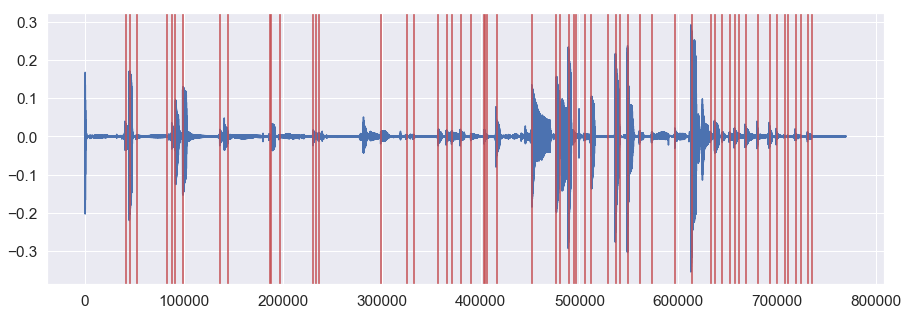

In [362]:
annotation = jams.load(solo_files_paths[0])
onset_annotation = visualize_jams_onset_asList(annotation, visualize = False)
plt.plot(all_audio_files[0][2])
for librosaOnset in onset_times:
    plt.axvline(x = librosaOnset * SAMPLE_RATE, color = 'r')
onset1str = []
for onset in onset_annotation:
    if onset[1] == 0:
        plt.axvline(x = (onset[0] * SAMPLE_RATE), color = 'g')

print (onset_annotation)

In [361]:
onsetstr1 = []
for onset in onset_annotation:
    if onset[1] == 2:
        onsetstr1.append(onset[0])
np.multiply(onsetstr1, SAMPLE_RATE)

maxerror = 0.1
final_onset_str1 = []
final_onset_time = []
for onset_num in onsetstr1:
    num = np.argmin(np.abs((onset_num-onset_times)))
    if onset_times[num] - onset_num < maxerror:
        final_onset_str1.append(num)
        final_onset_time.append(onset_times[num])
print (final_onset_str1)
print (final_onset_time)

[1, 5, 6, 6, 27, 28, 29, 29, 30, 34, 36, 38, 42, 42]
[2.066575963718821, 4.133151927437642, 4.504671201814059, 4.504671201814059, 20.48, 21.61777777777778, 21.803537414965987, 21.803537414965987, 22.19827664399093, 23.196734693877552, 24.33451247165533, 24.891791383219953, 27.817505668934242, 27.817505668934242]


In [325]:
# Extracting all clips corresponding to onset times from individual strings
all_clips = []   
i = 0
for onset in all_librosa_onsets:    
    audio = all_audio_files[i]
    i = i+1
    onsets_clip = clip_from_onset_multiplefiles(onset, SAMPLE_RATE, audio)
    all_clips.append(onsets_clip)   

In [326]:
def features_extract(audio, w, n_fft, hop_length, n_lift):
    """returns CP (n-lift coefficients), variance, kurtosis and skewness of n_lift power cepstral
    coefficients as input features to the model"""
    coefficients = []
    CP = []
    for x in audio:
        CP_onset = power_cepstrum(x, w, n_fft, hop_length, n_lift)
        CP.append(CP_onset)
    CP = np.array(CP)
    
    # Variance
    CP_var = []
    for i in np.arange(CP.shape[0]):
        CP_var_file = np.array([])
        for coeff in np.arange(n_lift-1):
            CP_var_coeff = np.var(CP[i][:, coeff])
            CP_var_file = np.append(CP_var_file, CP_var_coeff)
        CP_var.append(CP_var_file)
        
    # Kurtosis
    CP_kurt = []
    for i in np.arange(CP.shape[0]):
        CP_kurt_file = np.array([])
        for coeff in np.arange(n_lift-1):
            CP_kurt_coeff = stats.kurtosis(CP[i][:, coeff])
            CP_kurt_file = np.append(CP_kurt_file, CP_kurt_coeff)
        CP_kurt.append(CP_kurt_file)
        
    # Skewness
    CP_skew = []
    for i in np.arange(CP.shape[0]):
        CP_skew_file = np.array([])
        for coeff in np.arange(n_lift-1):
            CP_skew_coeff = stats.skew(CP[i][:, coeff])
            CP_skew_file = np.append(CP_skew_file, CP_skew_coeff)
        CP_skew.append(CP_skew_file)
    
    coefficients.append(CP_var)
    coefficients.append(CP_kurt)
    coefficients.append(CP_skew)
    coefficients = np.array(coefficients)
    return coefficients, CP

In [327]:
all_coeff = []
all_CP = []
for clip in all_clips:
    coeff_file, CP_file = features_extract(clip, w, n_fft, hop_length, n_lift)
    all_coeff.append(coeff_file)
    all_CP.append(CP_file)

In [328]:
# Preparing final file containing all feature vectors and metadata

CP_var = column_name_gen('CP_var', n_lift)
CP_kurt = column_name_gen('CP_kurt', n_lift)
CP_skew = column_name_gen('CP_skew', n_lift)
column_names = [CP_var, CP_kurt, CP_skew]
df = pd.DataFrame()
for file_count in np.arange(len(all_coeff)):
    stat_prop_df = pd.DataFrame()
    for stat_prop_count in np.arange(len(all_coeff[file_count])):
        file_coeff = pd.DataFrame(all_coeff[file_count][stat_prop_count])
        file_coeff.columns = column_names[stat_prop_count]      
        stat_prop_df = pd.concat([stat_prop_df, file_coeff], axis = 1)    
    stat_prop_df['Performer'] = solo_audio_paths[file_count].split('/')[3].split('_')[0]
    stat_prop_df['Genre'] = solo_audio_paths[file_count].split('/')[3].split('_')[1].split('-')[0][:-1]
    stat_prop_df['OnsetTime'] = all_librosa_onsets[file_count][:, 0]
    stat_prop_df['OnsetString'] = all_librosa_onsets[file_count][:, 1]
    stat_prop_df['FileName'] = solo_audio_paths[file_count].split('/')[3]
    df = pd.concat([df, stat_prop_df], axis = 0)

In [329]:
print (len(all_coeff))
print (len(all_coeff[0]))
print (len(all_coeff[0][0]))
print (len(all_coeff[0][0][50]))

180
3
68
199


In [330]:
df.to_csv('GuitarSetCoeffRaw_300msCP200_v1.csv')

<font size = 4> <b> SVM Model training

In [182]:
# Reading data from excel
features = pd.read_csv("UnbiasedDataset_CPfeatures_LibrosaOnsets_300msCP200_v1.csv")

# Removing extra column
features = features.drop(['Unnamed: 0'], axis = 1)

# reassigning filename to index
features = features.set_index('filename')
features.head()

,style,tone,onset,onset_num,CP_var_C1,CP_var_C2,CP_var_C3,CP_var_C4,CP_var_C5,CP_var_C6,...,CP_skew_C190,CP_skew_C191,CP_skew_C192,CP_skew_C193,CP_skew_C194,CP_skew_C195,CP_skew_C196,CP_skew_C197,CP_skew_C198,CP_skew_C199
filename,,,,,,,,,,,,,,,,,,,,,
hamming_whole_step_19_1.wav,hamming,7,68608.0,1,0.000011,0.000008,0.000005,1.745923e-06,4.959083e-07,1.946787e-07,...,-0.093928,-0.030892,-0.071242,-0.152651,0.047739,0.297994,0.963732,0.863878,0.868269,0.847967
hamming_whole_step_24_1.wav,hamming,7,67584.0,1,0.000006,0.000004,0.000002,1.202588e-06,6.890216e-07,2.765348e-07,...,0.595981,0.184870,-0.695615,-0.005264,1.169029,1.398972,0.798193,-0.184932,-0.525978,-0.574988
hamming_whole_step_8_1.wav,hamming,7,64000.0,1,0.000006,0.000003,0.000002,1.200772e-06,1.156377e-06,9.766886e-07,...,-0.932572,-0.744592,-0.278905,0.244431,-0.341609,-0.262123,-0.240591,-0.239871,-0.252289,-0.278978
hamming_whole_step_26_1.wav,hamming,7,68096.0,1,0.000009,0.000006,0.000003,9.740621e-07,5.923217e-07,6.748762e-07,...,1.431441,0.971167,0.109226,-0.210691,-0.821031,0.159194,0.598503,0.678842,0.415134,0.343278
hamming_whole_step_22_1.wav,hamming,7,65536.0,1,0.000007,0.000004,0.000002,1.411202e-06,9.426419e-07,6.491488e-07,...,-0.479614,-0.394339,-0.258078,-0.255157,-0.374219,-0.690906,-0.557743,-0.497075,-0.501951,-0.409321


In [183]:
from sklearn.preprocessing import LabelEncoder

sle = LabelEncoder()
style_labels = sle.fit_transform(features['style'])
style_mappings = {index: label for index, label in 
                  enumerate(sle.classes_)}
style_mappings

{0: 'bending',
 1: 'hamming',
 2: 'mute',
 3: 'normal',
 4: 'pulling',
 5: 'slide',
 6: 'trill'}

In [184]:
features['styleLabel'] = style_labels
features = features.drop(['style'], axis = 1)

In [185]:
# Splitting data into x and y
X = features.drop(['styleLabel', 'tone', 'onset', 'onset_num'], axis = 1)
y = features['styleLabel']

In [186]:
# Scaling using mean, std dev

from sklearn.preprocessing import scale
X = scale(X)


# Scaling using minmaxscaler

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(X)
# X = scaler.transform(X)


In [187]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4)

In [188]:
# confirm that splitting also has similar distribution of styles 
print(y_train.mean())
print(y_test.mean())

3.1208602150537637
3.0561685055165495


In [189]:
# Model building

# instantiate an object of class SVC()
model = SVC(C = 3)

# fit
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

In [190]:
# Evaluate the model using confusion matrix 
from sklearn import metrics
ConfusionMatrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

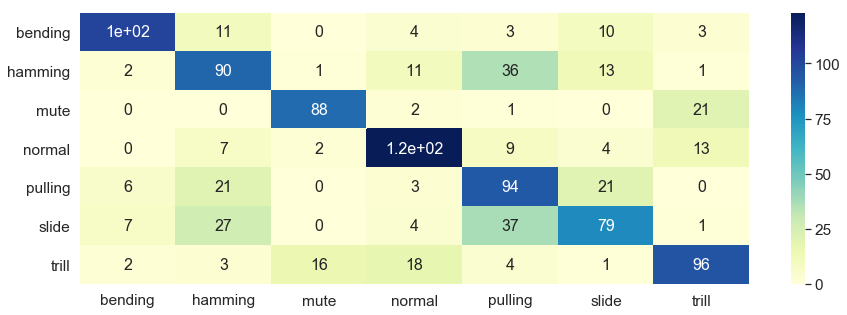

In [191]:
ConfusionMatrix = pd.DataFrame(ConfusionMatrix)
ConfusionMatrix = ConfusionMatrix.rename(index = style_mappings, columns = style_mappings)

plt.rcParams['figure.figsize']=[15,5]
sns.set(font_scale=1.4)
sns.heatmap(ConfusionMatrix, cmap="YlGnBu", annot=True, annot_kws={"size":16});

In [192]:
# print other metrics

# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))

# precision
print("precision", metrics.precision_score(y_test, y_pred, average = None))

# recall/sensitivity
print("recall", metrics.recall_score(y_test, y_pred, average = None))

# F-Score
print ('F-Score', metrics.f1_score(y_test, y_pred, average = None), np.mean(metrics.f1_score(y_test, y_pred, average = None)))

accuracy 0.6740220661985958
precision [0.85714286 0.56603774 0.82242991 0.74545455 0.51086957 0.6171875
 0.71111111]
recall [0.76691729 0.58441558 0.78571429 0.77848101 0.64827586 0.50967742
 0.68571429]
F-Score [0.80952381 0.57507987 0.80365297 0.76160991 0.57142857 0.55830389
 0.69818182] 0.6825401190602485


In [193]:
y_df = pd.DataFrame(y)
y_df['styleLabel'].value_counts()

3    525
4    515
1    504
5    498
6    490
0    423
2    367
Name: styleLabel, dtype: int64

<font size = 4> <b> Preparing NYU GuitarSet Onset datafile for classification

In [331]:
df = pd.read_csv('GuitarSetCoeffRaw_300msCP200_v1.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

,CP_var_C1,CP_var_C2,CP_var_C3,CP_var_C4,CP_var_C5,CP_var_C6,CP_var_C7,CP_var_C8,CP_var_C9,CP_var_C10,...,CP_skew_C195,CP_skew_C196,CP_skew_C197,CP_skew_C198,CP_skew_C199,Performer,Genre,OnsetTime,OnsetString,FileName
0,0.000018,0.000007,0.000002,1.524235e-06,6.037013e-07,5.931118e-07,1.948051e-07,2.900507e-07,2.303153e-07,1.793299e-07,...,0.409263,0.235750,0.318558,0.464753,0.514360,4,Jazz,1.834376,1.0,04_Jazz2-110-Bb_solo_hex.wav
1,0.000014,0.000006,0.000002,1.650505e-06,9.013374e-07,7.158438e-07,5.301922e-07,3.692586e-07,3.105505e-07,2.162537e-07,...,0.587433,0.924863,0.629719,0.719985,0.863675,4,Jazz,3.970612,1.0,04_Jazz2-110-Bb_solo_hex.wav
2,0.000036,0.000008,0.000003,1.568952e-06,5.573339e-07,4.518095e-07,2.619887e-07,2.383685e-07,1.564162e-07,1.350938e-07,...,0.898437,0.611092,0.823669,0.478163,0.859334,4,Jazz,2.043356,2.0,04_Jazz2-110-Bb_solo_hex.wav
3,0.000011,0.000004,0.000001,5.414562e-07,4.814090e-07,6.322352e-07,3.262676e-07,4.421935e-07,3.356079e-07,3.345352e-07,...,0.193026,0.296168,0.202105,0.205958,0.315238,4,Jazz,4.179592,2.0,04_Jazz2-110-Bb_solo_hex.wav
4,0.000013,0.000005,0.000001,8.178563e-07,4.820556e-07,3.001135e-07,1.921186e-07,1.626730e-07,1.359511e-07,1.236353e-07,...,-0.378982,-0.440630,-0.064612,-0.116769,-0.183046,4,Jazz,4.504671,2.0,04_Jazz2-110-Bb_solo_hex.wav


In [332]:
# Extracting feature vectors from NYU GuitarSet
X_test_NYU = df.drop(['Performer', 'Genre', 'OnsetTime', 'OnsetString' ,'FileName'], axis = 1)
X_test_NYU = pd.DataFrame(scale(X_test_NYU))
X_test_NYU.describe()

,0,1,2,3,4,5,6,7,8,9,...,587,588,589,590,591,592,593,594,595,596
count,1.596700e+04,1.596700e+04,1.596700e+04,1.596700e+04,1.596700e+04,1.596700e+04,1.596700e+04,1.596700e+04,1.596700e+04,1.596700e+04,...,1.596700e+04,1.596700e+04,1.596700e+04,1.596700e+04,1.596700e+04,1.596700e+04,1.596700e+04,1.596700e+04,1.596700e+04,1.596700e+04
mean,-2.256603e-16,7.817174e-17,1.309920e-16,1.173706e-17,1.344338e-16,1.173376e-16,-4.797732e-17,-3.541978e-17,6.313537e-17,-3.111920e-17,...,2.104049e-17,-5.429781e-17,4.636417e-17,-3.771435e-17,8.858421e-18,1.917702e-17,-1.266949e-16,-8.440184e-17,-4.002282e-17,-1.199433e-16
std,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,...,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00
min,-1.464708e+00,-1.335301e+00,-1.448810e+00,-1.300937e+00,-1.445032e+00,-1.249828e+00,-1.331506e+00,-1.071338e+00,-1.045201e+00,-6.842878e-01,...,-3.130345e+00,-3.277189e+00,-3.645325e+00,-3.525779e+00,-3.317679e+00,-3.240203e+00,-3.706203e+00,-3.204168e+00,-3.498827e+00,-3.390660e+00
25%,-7.429106e-01,-6.955941e-01,-7.041294e-01,-6.917724e-01,-6.947853e-01,-6.763512e-01,-6.615457e-01,-6.017872e-01,-5.810852e-01,-4.632528e-01,...,-7.195317e-01,-7.171559e-01,-7.019271e-01,-7.097734e-01,-7.150116e-01,-7.033814e-01,-7.021700e-01,-7.096311e-01,-7.202771e-01,-7.253988e-01
50%,-2.261115e-01,-2.456953e-01,-2.263856e-01,-2.615598e-01,-2.154101e-01,-2.653438e-01,-2.374756e-01,-2.734214e-01,-2.783738e-01,-2.893737e-01,...,-7.540008e-02,-6.247476e-02,-6.282422e-02,-5.182841e-02,-6.149372e-02,-5.907916e-02,-6.657698e-02,-6.351440e-02,-5.784084e-02,-6.809703e-02
75%,5.132804e-01,4.144503e-01,4.543154e-01,4.003297e-01,4.312564e-01,3.724970e-01,3.704831e-01,2.632802e-01,2.268371e-01,5.066365e-02,...,6.278030e-01,6.231313e-01,6.161330e-01,6.104864e-01,6.044878e-01,6.245584e-01,6.282802e-01,6.179773e-01,6.149897e-01,6.033518e-01
max,6.027874e+00,9.141426e+00,9.910041e+00,9.561102e+00,8.959679e+00,1.440399e+01,1.159138e+01,1.989253e+01,1.956179e+01,1.762088e+01,...,6.044587e+00,5.195726e+00,6.192028e+00,7.105438e+00,4.894404e+00,7.212394e+00,6.006940e+00,4.899812e+00,5.442323e+00,5.330215e+00


In [333]:
y_pred_NYU = model.predict(X_test_NYU)

In [334]:
analysis_df = pd.concat([df['FileName'], df['OnsetTime'], df['OnsetString'], df['Performer'], df['Genre']], axis = 1)
analysis_df['Style'] = y_pred_NYU
analysis_df.head()

,FileName,OnsetTime,OnsetString,Performer,Genre,Style
0,04_Jazz2-110-Bb_solo_hex.wav,1.834376,1.0,4,Jazz,6
1,04_Jazz2-110-Bb_solo_hex.wav,3.970612,1.0,4,Jazz,2
2,04_Jazz2-110-Bb_solo_hex.wav,2.043356,2.0,4,Jazz,3
3,04_Jazz2-110-Bb_solo_hex.wav,4.179592,2.0,4,Jazz,3
4,04_Jazz2-110-Bb_solo_hex.wav,4.504671,2.0,4,Jazz,0


In [335]:
expression_count = analysis_df[(analysis_df.FileName == '04_Jazz2-110-Bb_solo_hex.wav') & (analysis_df.Style == 6)].count()[0]
expression_count

14

In [336]:
analysis_df.loc[analysis_df['FileName'] == '04_Jazz2-110-Bb_solo_hex.wav']

,FileName,OnsetTime,OnsetString,Performer,Genre,Style
0,04_Jazz2-110-Bb_solo_hex.wav,1.834376,1.0,4,Jazz,6
1,04_Jazz2-110-Bb_solo_hex.wav,3.970612,1.0,4,Jazz,2
2,04_Jazz2-110-Bb_solo_hex.wav,2.043356,2.0,4,Jazz,3
3,04_Jazz2-110-Bb_solo_hex.wav,4.179592,2.0,4,Jazz,3
4,04_Jazz2-110-Bb_solo_hex.wav,4.504671,2.0,4,Jazz,0
5,04_Jazz2-110-Bb_solo_hex.wav,4.667211,2.0,4,Jazz,3
6,04_Jazz2-110-Bb_solo_hex.wav,20.456780,2.0,4,Jazz,3
7,04_Jazz2-110-Bb_solo_hex.wav,21.617778,2.0,4,Jazz,6
8,04_Jazz2-110-Bb_solo_hex.wav,21.873197,2.0,4,Jazz,5
9,04_Jazz2-110-Bb_solo_hex.wav,21.966077,2.0,4,Jazz,5


In [337]:
np.unique(analysis_df['Genre'])

array(['BN', 'Funk', 'Jazz', 'Rock', 'SS'], dtype=object)

In [338]:
style_by_genre = []
for genre in np.unique(analysis_df['Genre']):
    style_temp = []
    for style in np.arange(7):
        style_count = analysis_df[(analysis_df.Genre == genre) & (analysis_df.Style == style)].count()[0]
        style_temp.append(style_count)
    style_by_genre.append(style_temp)

In [339]:
# Defining mappings:
"""
{0: 'bending',
 1: 'hamming',
 2: 'mute',
 3: 'normal',
 4: 'pulling',
 5: 'slide',
 6: 'trill'}
"""
label_map = ['bending', 'hamming', 'mute', 'normal', 'pulling', 'slide', 'trill']

"""
Order:
['BN', 'Funk', 'Jazz', 'Rock', 'SS']
"""
genre_map = ['BN', 'Funk', 'Jazz', 'Rock', 'SS'] # Based on np.unique(Genre)

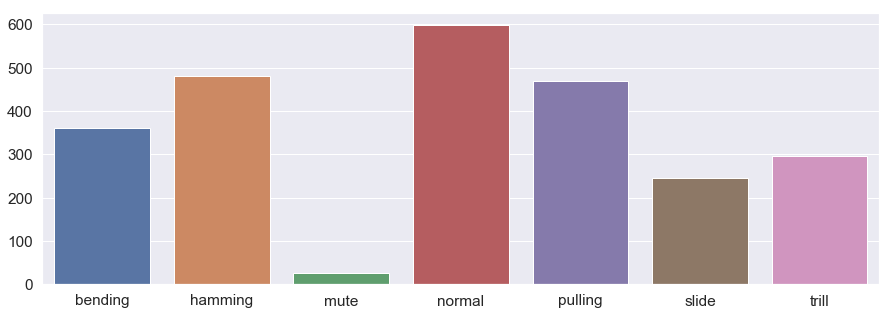

In [340]:
# Bossa Nova
sns.barplot(x=label_map, y=style_by_genre[0])

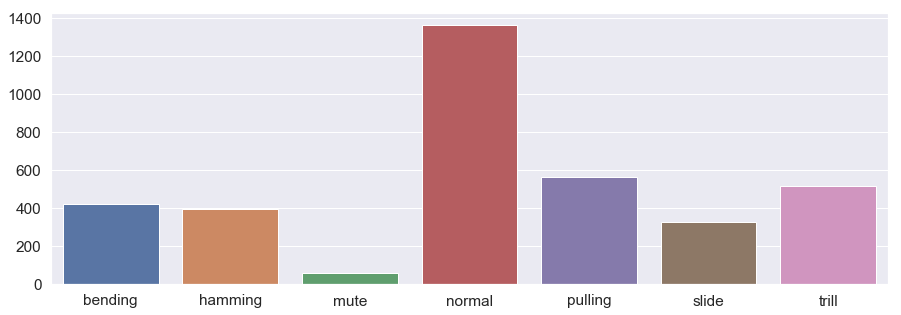

In [341]:
# Funk
sns.barplot(x=label_map, y=style_by_genre[1])

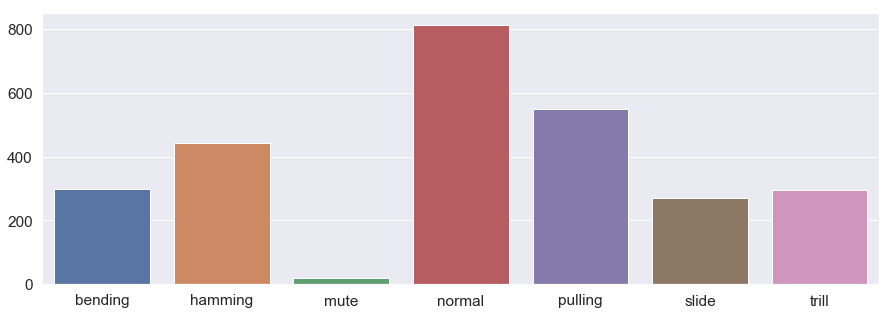

In [342]:
# Jazz
sns.barplot(x=label_map, y=style_by_genre[2])

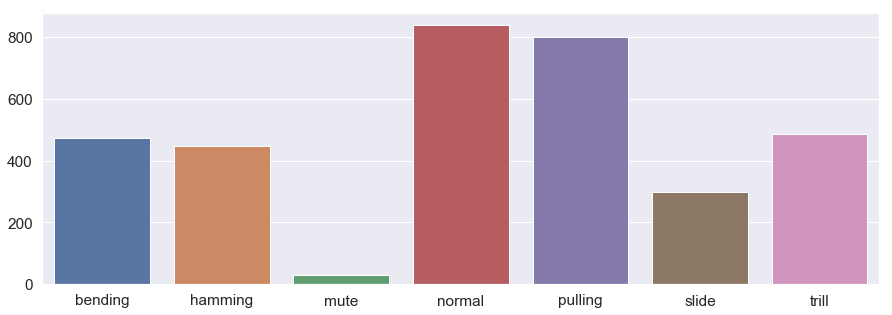

In [343]:
# Rock
sns.barplot(x=label_map, y=style_by_genre[3])

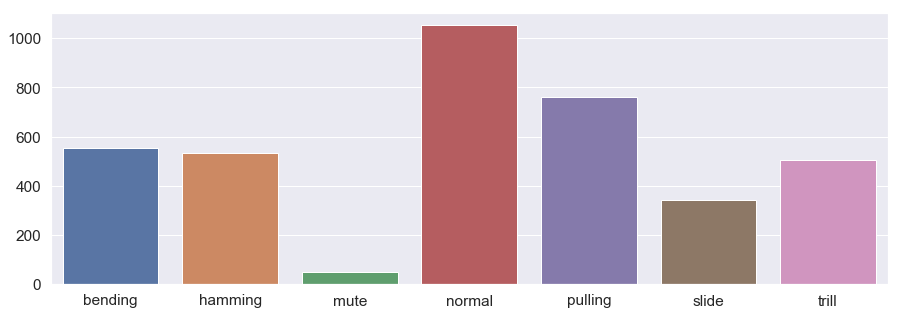

In [344]:
# Singer-Songwriter
sns.barplot(x=label_map, y=style_by_genre[4])

In [345]:
style_by_genre

[[360, 481, 26, 597, 468, 245, 295],
 [421, 395, 61, 1360, 563, 326, 519],
 [299, 442, 21, 811, 548, 270, 296],
 [472, 447, 29, 837, 799, 297, 485],
 [552, 533, 49, 1052, 763, 342, 506]]

In [346]:
style_by_genre_normalised = []
for genre_temp in style_by_genre:
    genre_split = []
    for i in np.arange(len(genre_temp)):
        percent = genre_temp[i]/np.sum(genre_temp)
        genre_split.append(percent)
    style_by_genre_normalised.append(genre_split)

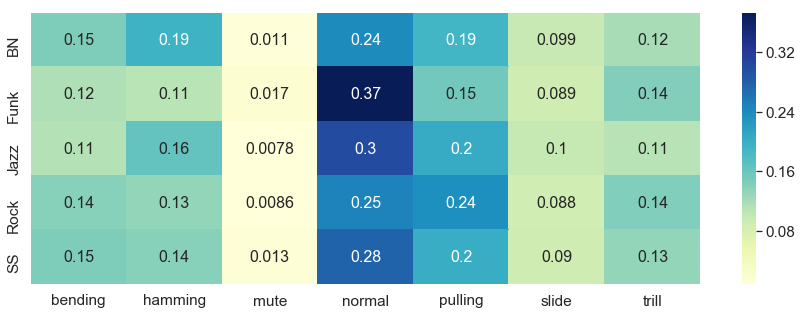

In [347]:
sns.heatmap(style_by_genre_normalised, cmap="YlGnBu", annot=True, annot_kws={"size":16}, xticklabels=label_map, yticklabels = genre_map);

In [363]:
analysis_df.to_csv('ClassifiedOnsetsGuitarSet_300msCP200_v1.csv')